In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Dropout, Flatten
from keras import callbacks, optimizers
from keras_tqdm import TQDMNotebookCallback

import os
import glob
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

%matplotlib inline

In [17]:
# our parameters
train_data_pth = os.getcwd() + '/../data/train/'
validation_data_pth = os.getcwd() + '/../data/validation/'
log_pth = os.getcwd() + '/../data/logs/'
n_train_samples = 1800
n_validation_samples = 100
n_epochs = 3
batch_size = 20
n_classes = 4
img_width, img_height = 80, 80
input_shape = (img_width, img_height, 3)

In [18]:
train_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_pth,
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical')

Found 1200 images belonging to 4 classes.


In [19]:
validation_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_pth, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='categorical')

Found 240 images belonging to 4 classes.


In [28]:
# sets up the model shape
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.05))

model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.05))

model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [29]:
# runs the model
model.fit_generator(
    train_generator, 
    validation_data=validation_generator,
    steps_per_epoch=int(n_train_samples / batch_size),
    validation_steps=int(n_validation_samples / batch_size), 
    epochs=n_epochs, verbose=0, callbacks=[TQDMNotebookCallback()]
)

In [25]:
folders = ['bart', 'hommer', 'lisa', 'marge']
y = []
y_hat = []

for i in range(len(folders)):
    files = glob.glob(validation_data_pth + folders[i] + '/*.jpg')
    for f in files:
        img = Image.open(f)
        y.append(i)
        y_hat.append(model.predict_classes(np.expand_dims(np.asarray(img), axis=0))[0])

1/1 [==============================] - 0s


In [26]:
sum(1 for i, j in zip(y_hat, y) if i == j) / float(len(y_hat))

0.5333333333333333

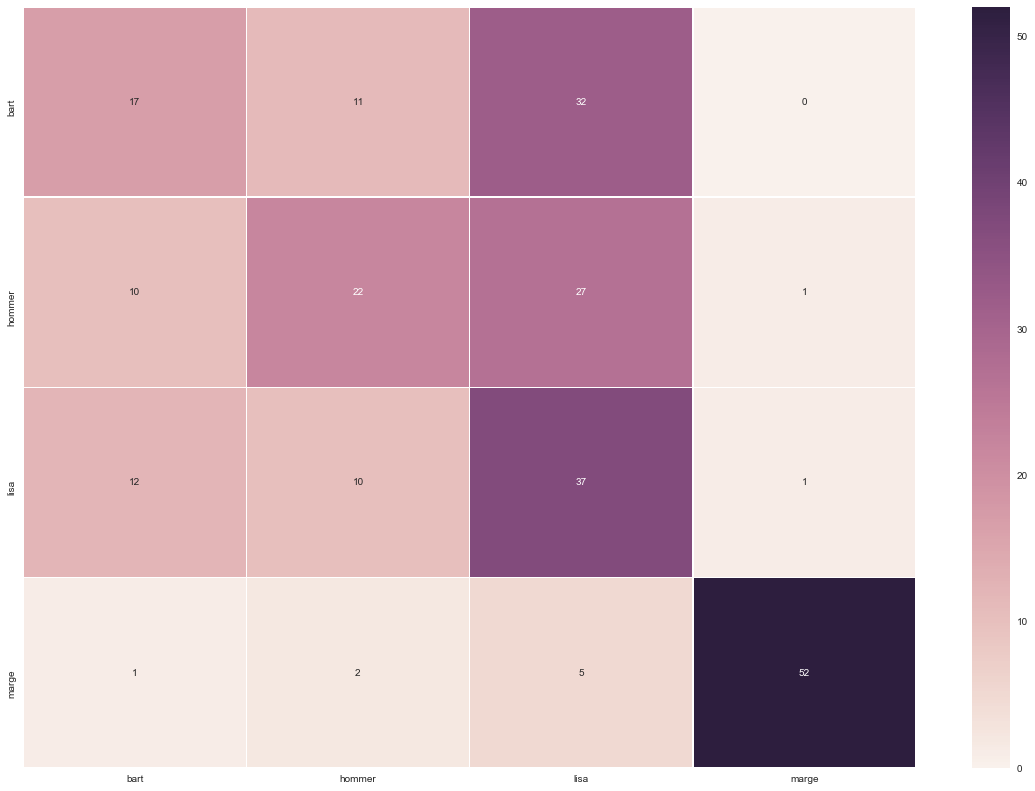

In [27]:
conf_matrix = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
for i in range(len(y)):
    conf_matrix[y[i]][y_hat[i]] += 1

df_cm = pd.DataFrame(conf_matrix, index = ['bart', 'hommer', 'lisa', 'marge'],
                  columns = ['bart', 'hommer', 'lisa', 'marge'])

plt.figure(figsize = (20, 14))
sn.heatmap(df_cm, annot=True, linewidths=0.5, fmt='g')